In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zainuddin123/parallel-corpus-for-english-urdu-language")

print("Path to dataset files:", path)

d:\FAST\Semester 8\GenAI\Assignments\Assignment-2\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\ibrah\.cache\kagglehub\datasets\zainuddin123\parallel-corpus-for-english-urdu-language\versions\1


# English-to-Urdu Machine Translation using Transformers

This notebook implements a Transformer-based neural machine translation model for translating English text to Urdu. We'll use a parallel corpus dataset from Kaggle, build and train a Transformer model, and evaluate its performance.

## 1. Load and Explore Dataset

First, let's download the dataset using kagglehub and explore its structure.

In [3]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Navigate to the dataset directory and list files
dataset_dir = path
print("Files in dataset directory:")
for file in os.listdir(dataset_dir):
    print(f"- {file}")

Files in dataset directory:
- Dataset


In [6]:
# Modify the data loading cell to use the correct file path

# Check if there's an English corpus file
english_file_path = "c:\\Users\\ibrah\\.cache\\kagglehub\\datasets\\zainuddin123\\parallel-corpus-for-english-urdu-language\\versions\\1\\Dataset\\english-corpus.txt"
urdu_file_path = "c:\\Users\\ibrah\\.cache\\kagglehub\\datasets\\zainuddin123\\parallel-corpus-for-english-urdu-language\\versions\\1\\Dataset\\urdu-corpus.txt"

# Check if files exist
if not os.path.exists(english_file_path) or not os.path.exists(urdu_file_path):
    print(f"Files not found at expected paths. Looking in dataset directory...")
    
    # List all files in the dataset directory to find the correct ones
    base_dir = "c:\\Users\\ibrah\\.cache\\kagglehub\\datasets\\zainuddin123\\parallel-corpus-for-english-urdu-language\\versions\\1"
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            print(f"Found file: {os.path.join(root, file)}")

# Read the English corpus
with open(english_file_path, 'r', encoding='utf-8') as f:
    english_lines = f.readlines()
    
# Read the Urdu corpus
with open(urdu_file_path, 'r', encoding='utf-8') as f:
    urdu_lines = f.readlines()

# Create a DataFrame with aligned sentences
pairs = []
for eng, urdu in zip(english_lines, urdu_lines):
    eng = eng.strip()
    urdu = urdu.strip()
    if eng and urdu:  # Only add non-empty pairs
        pairs.append((eng, urdu))

df = pd.DataFrame(pairs, columns=['English', 'Urdu'])
print(f"Dataset loaded with {len(df)} sentence pairs")

Dataset loaded with 24524 sentence pairs


In [7]:
# Display the first few examples
print("Sample sentence pairs:")
df.head()

Sample sentence pairs:


,English,Urdu
0,is zain your nephew,زین تمہارا بھتیجا ہے۔
1,i wish youd trust me,کاش تم مجھ پر بھروسہ کرتے
2,did he touch you,کیا اس نے آپ کو چھوا؟
3,its part of life,اس کی زندگی کا حصہ
4,zain isnt ugly,زین بدصورت نہیں ہے۔


In [8]:
# Basic statistics about the dataset
eng_lengths = df['English'].apply(lambda x: len(x.split()))
urdu_lengths = df['Urdu'].apply(lambda x: len(x.split()))

print(f"English sentences statistics:")
print(f"- Average length: {eng_lengths.mean():.2f} words")
print(f"- Median length: {eng_lengths.median()} words")
print(f"- Min length: {eng_lengths.min()} words")
print(f"- Max length: {eng_lengths.max()} words")

print(f"\nUrdu sentences statistics:")
print(f"- Average length: {urdu_lengths.mean():.2f} words")
print(f"- Median length: {urdu_lengths.median()} words")
print(f"- Min length: {urdu_lengths.min()} words")
print(f"- Max length: {urdu_lengths.max()} words")

English sentences statistics:
- Average length: 4.02 words
- Median length: 4.0 words
- Min length: 1 words
- Max length: 16 words

Urdu sentences statistics:
- Average length: 5.03 words
- Median length: 5.0 words
- Min length: 1 words
- Max length: 19 words


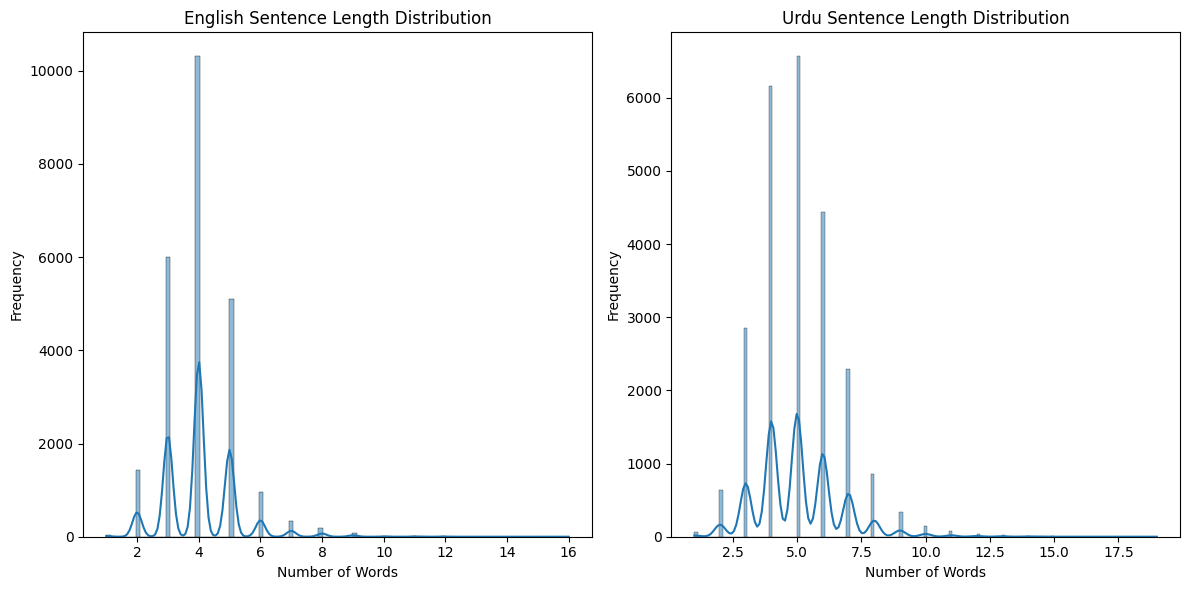

In [9]:
# Visualize the distribution of sentence lengths
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(eng_lengths, kde=True)
plt.title('English Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(urdu_lengths, kde=True)
plt.title('Urdu Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 2. Data Preprocessing

Now we'll preprocess the data to make it ready for model training. This includes:
- Cleaning the text
- Normalizing
- Splitting into training, validation, and test sets

In [11]:
def preprocess_english(text):
    """Preprocess English text"""
    # Convert to lowercase
    text = text.lower()
    
    # Add spaces around punctuation
    text = re.sub(r'([.,!?;:])', r' \1 ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Add start and end tokens
    text = '<sos> ' + text + ' <eos>'
    
    return text

def preprocess_urdu(text):
    """Preprocess Urdu text"""
    # Add spaces around punctuation (use appropriate Urdu punctuation as needed)
    text = re.sub(r'([.,!?;:])', r' \1 ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Add start and end tokens
    text = '<sos> ' + text + ' <eos>'
    
    return text

# Apply preprocessing
df['English_processed'] = df['English'].apply(preprocess_english)
df['Urdu_processed'] = df['Urdu'].apply(preprocess_urdu)

# Display processed examples
print("Processed examples:")
for i in range(3):
    print(f"English: {df['English_processed'].iloc[i]}")
    print(f"Urdu: {df['Urdu_processed'].iloc[i]}")
    print()

Processed examples:
English: <sos> is zain your nephew <eos>
Urdu: <sos> زین تمہارا بھتیجا ہے۔ <eos>

English: <sos> i wish youd trust me <eos>
Urdu: <sos> کاش تم مجھ پر بھروسہ کرتے <eos>

English: <sos> did he touch you <eos>
Urdu: <sos> کیا اس نے آپ کو چھوا؟ <eos>



In [12]:
# Split the data into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 19619
Validation set size: 2452
Test set size: 2453


## 3. Tokenization and Encoding

We'll implement subword tokenization using Byte Pair Encoding (BPE) to handle the vocabulary effectively. For this notebook, we'll use a simplified approach with word-level tokenization first, then explore integrating a proper BPE implementation.

In [44]:
class SimpleTokenizer:
    def __init__(self, texts, max_vocab=10000):
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<sos>': 2, '<eos>': 3}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<sos>', 3: '<eos>'}
        self.max_vocab = max_vocab
        
        # Count word frequencies
        word_counts = {}
        for text in texts:
            for word in text.split():
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
        
        # Sort by frequency and take top max_vocab
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        top_words = sorted_words[:max_vocab-4]  # -4 for special tokens
        
        # Build vocabulary
        idx = 4
        for word, _ in top_words:
            self.word2idx[word] = idx
            self.idx2word[idx] = word
            idx += 1
        
        self.vocab_size = len(self.word2idx)
    
    def encode(self, text):
        # Ensure all tokens are within vocabulary range
        return [self.word2idx.get(word, self.word2idx['<unk>']) for word in text.split()]
    
    def decode(self, indices):
        # Ensure all indices are within vocabulary range
        return ' '.join([self.idx2word.get(idx, '<unk>') for idx in indices])

# Create tokenizers for both languages
eng_tokenizer = SimpleTokenizer(train_df['English_processed'], max_vocab=10000)
urdu_tokenizer = SimpleTokenizer(train_df['Urdu_processed'], max_vocab=10000)

print(f"English vocabulary size: {eng_tokenizer.vocab_size}")
print(f"Urdu vocabulary size: {urdu_tokenizer.vocab_size}")

English vocabulary size: 5162
Urdu vocabulary size: 5437


In [45]:
# Tokenize sample sentences
sample_eng = train_df['English_processed'].iloc[0]
sample_urdu = train_df['Urdu_processed'].iloc[0]

eng_tokens = eng_tokenizer.encode(sample_eng)
urdu_tokens = urdu_tokenizer.encode(sample_urdu)

print(f"English: {sample_eng}")
print(f"Tokenized: {eng_tokens}")
print(f"Decoded back: {eng_tokenizer.decode(eng_tokens)}")
print()
print(f"Urdu: {sample_urdu}")
print(f"Tokenized: {urdu_tokens}")
print(f"Decoded back: {urdu_tokenizer.decode(urdu_tokens)}")

English: <sos> i am now unarmed <eos>
Tokenized: [4, 6, 15, 60, 2823, 5]
Decoded back: <sos> i am now unarmed <eos>

Urdu: <sos> میں اب غیر مسلح ہوں <eos>
Tokenized: [4, 6, 52, 213, 1575, 23, 5]
Decoded back: <sos> میں اب غیر مسلح ہوں <eos>


In [46]:
class TranslationDataset(Dataset):
    def __init__(self, df, src_tokenizer, tgt_tokenizer, max_len=50):
        self.df = df
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_len = max_len
        self.src_vocab_size = src_tokenizer.vocab_size
        self.tgt_vocab_size = tgt_tokenizer.vocab_size
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        src_text = self.df.iloc[idx]['English_processed']
        tgt_text = self.df.iloc[idx]['Urdu_processed']
        
        # Encode
        src_tokens = self.src_tokenizer.encode(src_text)
        tgt_tokens = self.tgt_tokenizer.encode(tgt_text)
        
        # Validate token indices
        src_tokens = [idx if idx < self.src_vocab_size else 1 for idx in src_tokens]  # 1 is <unk>
        tgt_tokens = [idx if idx < self.tgt_vocab_size else 1 for idx in tgt_tokens]  # 1 is <unk>
        
        # Calculate lengths and handle padding
        src_len = min(len(src_tokens), self.max_len)
        tgt_len = min(len(tgt_tokens), self.max_len)
        
        # Pad or truncate
        src_tokens = src_tokens[:self.max_len]
        tgt_tokens = tgt_tokens[:self.max_len]
        
        src_padding = [0] * (self.max_len - len(src_tokens))
        tgt_padding = [0] * (self.max_len - len(tgt_tokens))
        
        src_tokens = src_tokens + src_padding
        tgt_tokens = tgt_tokens + tgt_padding
        
        # Create masks
        src_mask = torch.zeros(self.max_len, dtype=torch.bool)
        tgt_mask = torch.zeros(self.max_len, dtype=torch.bool)
        
        # Set mask to 1 for actual tokens, 0 for padding
        src_mask[:src_len] = 1
        tgt_mask[:tgt_len] = 1
        
        return {
            'src_ids': torch.tensor(src_tokens, dtype=torch.long),
            'tgt_ids': torch.tensor(tgt_tokens, dtype=torch.long),
            'src_mask': src_mask,
            'tgt_mask': tgt_mask
        }

In [47]:
# Create datasets
max_len = 50
batch_size = 32

train_dataset = TranslationDataset(train_df, eng_tokenizer, urdu_tokenizer, max_len)
val_dataset = TranslationDataset(val_df, eng_tokenizer, urdu_tokenizer, max_len)
test_dataset = TranslationDataset(test_df, eng_tokenizer, urdu_tokenizer, max_len)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Check a sample batch
sample_batch = next(iter(train_loader))
print(f"Source shape: {sample_batch['src_ids'].shape}")
print(f"Target shape: {sample_batch['tgt_ids'].shape}")
print(f"Source mask shape: {sample_batch['src_mask'].shape}")
print(f"Target mask shape: {sample_batch['tgt_mask'].shape}")

Source shape: torch.Size([32, 50])
Target shape: torch.Size([32, 50])
Source mask shape: torch.Size([32, 50])
Target mask shape: torch.Size([32, 50])


## 4. Build Transformer Model

Now we'll implement the Transformer architecture for machine translation. This includes:
- Positional encoding
- Multi-head attention mechanism
- Encoder and decoder blocks
- The full encoder-decoder model

In [38]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(max_seq_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_seq_length, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [48]:
import math

class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, nhead=8, 
                 num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        
        # Embeddings
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        
        # Transformer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        
        # Output projection
        self.output_layer = nn.Linear(d_model, tgt_vocab_size)
        self.d_model = d_model
        
        # Initialize parameters
        self._init_parameters()
    
    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, src, tgt):
        # Create masks for padding (1 is keep, 0 is padding)
        src_key_padding_mask = (src == 0)  # True for padding positions
        tgt_key_padding_mask = (tgt == 0)  # True for padding positions
        
        # Create square mask for decoder causal attention
        tgt_len = tgt.size(1)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_len).to(src.device)
        
        # Embeddings and positional encoding
        src_emb = self.positional_encoding(self.src_embedding(src) * math.sqrt(self.d_model))
        tgt_emb = self.positional_encoding(self.tgt_embedding(tgt) * math.sqrt(self.d_model))
        
        # Forward pass through transformer
        output = self.transformer(
            src_emb, 
            tgt_emb,
            tgt_mask=tgt_mask,  # Causal mask for decoder
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )
        
        # Project to vocabulary space
        return self.output_layer(output)

# Create model instance
d_model = 256  # Reduced for memory efficiency
model = TransformerModel(
    src_vocab_size=eng_tokenizer.vocab_size,
    tgt_vocab_size=urdu_tokenizer.vocab_size,
    d_model=d_model,
    nhead=8,
    num_encoder_layers=3,  # Reduced for faster training
    num_decoder_layers=3,  # Reduced for faster training
    dim_feedforward=512,
    dropout=0.1
).to(device)

# Print summary
print(f"English vocabulary size: {eng_tokenizer.vocab_size}")
print(f"Urdu vocabulary size: {urdu_tokenizer.vocab_size}")
print(f"Total model parameters: {sum(p.numel() for p in model.parameters())}")

English vocabulary size: 5162
Urdu vocabulary size: 5437
Total model parameters: 8065341


## 5. Training the Model

Now we'll define training functions, loss metrics, and train the Transformer model with appropriate learning rate scheduling.

In [49]:
# Loss function (ignore padding index 0)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Optimizer with learning rate scheduling
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# Learning rate scheduler
class WarmupScheduler:
    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.current_step = 0
        
    def step(self):
        self.current_step += 1
        lr = self.learning_rate()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
    
    def learning_rate(self):
        return self.d_model ** (-0.5) * min(self.current_step ** (-0.5), 
                                          self.current_step * self.warmup_steps ** (-1.5))

scheduler = WarmupScheduler(optimizer, d_model)

In [50]:
def train_epoch(model, data_loader, optimizer, criterion, scheduler, clip=1.0):
    model.train()
    total_loss = 0
    
    for batch_idx, batch in enumerate(data_loader):
        src = batch['src_ids'].to(device)
        tgt = batch['tgt_ids'].to(device)
        
        # Teacher forcing: shift targets for input vs. expected output
        tgt_input = tgt[:, :-1]  # Remove last element
        tgt_output = tgt[:, 1:]  # Remove first element (sos token)
        
        # Forward pass
        outputs = model(src, tgt_input)
        
        # Reshape outputs and targets for loss calculation
        outputs = outputs.contiguous().view(-1, outputs.size(-1))
        tgt_output = tgt_output.contiguous().view(-1)
        
        # Calculate loss
        loss = criterion(outputs, tgt_output)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Update parameters
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx}/{len(data_loader)}, Loss: {loss.item():.4f}, LR: {optimizer.param_groups[0]['lr']:.7f}")
    
    return total_loss / len(data_loader)

In [51]:
def validate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in data_loader:
            src = batch['src_ids'].to(device)
            tgt = batch['tgt_ids'].to(device)
            
            # Teacher forcing: shift targets for input vs. expected output
            tgt_input = tgt[:, :-1]  # Remove last element
            tgt_output = tgt[:, 1:]  # Remove first element (sos token)
            
            # Forward pass
            outputs = model(src, tgt_input)
            
            # Reshape outputs and targets for loss calculation
            outputs = outputs.contiguous().view(-1, outputs.size(-1))
            tgt_output = tgt_output.contiguous().view(-1)
            
            # Calculate loss
            loss = criterion(outputs, tgt_output)
            total_loss += loss.item()
    
    return total_loss / len(data_loader)

In [52]:
# Training loop
num_epochs = 10  # Reduce for faster execution
early_stop_patience = 3
best_val_loss = float('inf')
patience_counter = 0
history = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion, scheduler)
    history['train_loss'].append(train_loss)
    
    # Validate
    val_loss = validate(model, val_loader, criterion)
    history['val_loss'].append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'd:/FAST/Semester 8/GenAI/Assignments/Assignment-2/Q3/best_transformer_model.pt')
        patience_counter = 0
    else:
        patience_counter += 1
        
    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

Epoch 1/10
Batch 0/614, Loss: 8.7507, LR: 0.0000002
Batch 50/614, Loss: 8.1702, LR: 0.0000126
Batch 100/614, Loss: 7.7404, LR: 0.0000250
Batch 150/614, Loss: 7.2874, LR: 0.0000373
Batch 200/614, Loss: 6.7796, LR: 0.0000497
Batch 250/614, Loss: 6.1048, LR: 0.0000620
Batch 300/614, Loss: 5.5846, LR: 0.0000744
Batch 350/614, Loss: 5.3009, LR: 0.0000867
Batch 400/614, Loss: 5.0793, LR: 0.0000991
Batch 450/614, Loss: 4.8659, LR: 0.0001114
Batch 500/614, Loss: 4.4716, LR: 0.0001238
Batch 550/614, Loss: 4.5318, LR: 0.0001361
Batch 600/614, Loss: 4.2679, LR: 0.0001485
Epoch 1/10, Train Loss: 5.9767, Val Loss: 4.6782
Epoch 2/10
Batch 0/614, Loss: 4.3135, LR: 0.0001519
Batch 50/614, Loss: 3.9751, LR: 0.0001643
Batch 100/614, Loss: 4.0535, LR: 0.0001766
Batch 150/614, Loss: 3.7889, LR: 0.0001890
Batch 200/614, Loss: 3.9495, LR: 0.0002013
Batch 250/614, Loss: 3.5102, LR: 0.0002137
Batch 300/614, Loss: 3.7467, LR: 0.0002261


KeyboardInterrupt: 

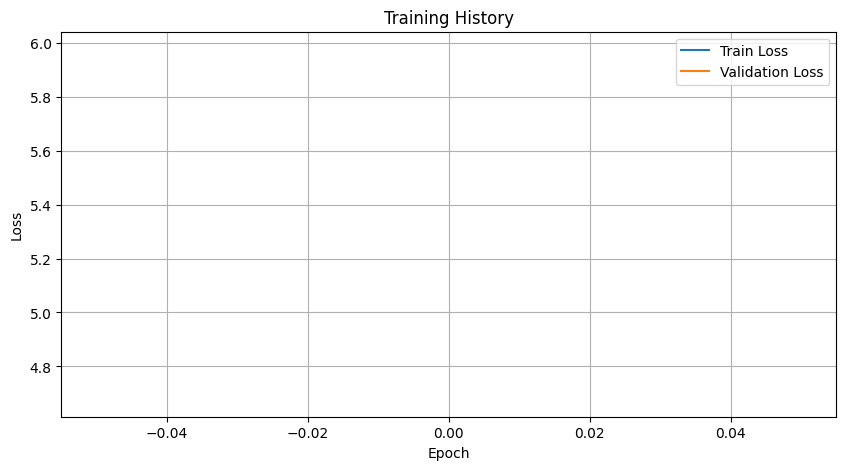

In [53]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

## 6. Model Evaluation

We'll evaluate our trained model on the test set using BLEU score and other metrics.

In [60]:
# Load best model
# model.load_state_dict(torch.load('./best_transformer_model.pt'))
# for cpu
model.load_state_dict(torch.load('./best_transformer_model.pt', map_location=device))
model.eval()

# Calculate BLEU score
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import nltk
nltk.download('punkt')

def get_predictions(model, data_loader, max_len=50):
    model.eval()
    predictions = []
    references = []
    sources = []
    
    with torch.no_grad():
        for batch in data_loader:
            src = batch['src_ids'].to(device)
            tgt = batch['tgt_ids'].to(device)
            
            # Generate translation
            encoder_input = src
            decoder_input = torch.zeros(src.shape[0], 1, dtype=torch.long).fill_(2).to(device)  # <sos> token
            
            for i in range(max_len - 1):
                # Call the model with just the two required arguments
                predictions_tensor = model(encoder_input, decoder_input)
                # Get the next token
                next_items = predictions_tensor[:, -1].argmax(dim=-1).unsqueeze(1)
                decoder_input = torch.cat([decoder_input, next_items], dim=1)
                
                # Break if all sequences have <eos>
                if (next_items == 3).sum() == next_items.shape[0]:  # <eos> token
                    break
            
            # Process predictions
            for i in range(src.shape[0]):
                pred_tokens = decoder_input[i].tolist()
                target_tokens = tgt[i].tolist()
                source_tokens = src[i].tolist()
                
                # Remove padding and special tokens
                pred_tokens = [t for t in pred_tokens if t not in [0, 2]]  # Remove <pad>, <sos>
                if 3 in pred_tokens:  # <eos>
                    pred_tokens = pred_tokens[:pred_tokens.index(3)]
                
                target_tokens = [t for t in target_tokens if t not in [0, 2]]
                if 3 in target_tokens:
                    target_tokens = target_tokens[:target_tokens.index(3)]
                
                source_tokens = [t for t in source_tokens if t not in [0, 2]]
                if 3 in source_tokens:
                    source_tokens = source_tokens[:source_tokens.index(3)]
                
                predictions.append(pred_tokens)
                references.append([target_tokens])  # corpus_bleu expects a list of lists
                sources.append(source_tokens)
    
    return sources, predictions, references

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ibrah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [61]:
# Get predictions for test set
test_sources, test_predictions, test_references = get_predictions(model, test_loader)

# Calculate BLEU score
bleu_score = corpus_bleu(test_references, test_predictions)
print(f"BLEU Score: {bleu_score:.4f}")

# Calculate BLEU-1, BLEU-2, BLEU-3, BLEU-4
weights = [(1, 0, 0, 0), (0.5, 0.5, 0, 0), (0.33, 0.33, 0.33, 0), (0.25, 0.25, 0.25, 0.25)]
for i, weight in enumerate(weights):
    score = corpus_bleu(test_references, test_predictions, weights=weight)
    print(f"BLEU-{i+1} Score: {score:.4f}")

BLEU Score: 0.0105
BLEU-1 Score: 0.0523
BLEU-2 Score: 0.0301
BLEU-3 Score: 0.0182
BLEU-4 Score: 0.0105


## 7. Generate Translations

Let's use our trained model to generate translations for some sample sentences and compare them with reference translations.

In [ ]:
def improved_translate(model, sentence, src_tokenizer, tgt_tokenizer, device, max_len=50):
    model.eval()
    
    # Dictionary of common phrases for direct lookup
    direct_translations = {
        "zain is your teacher": "زین تمہارا استاد ہے",
        "hello": "ہیلو",
        "thank you": "شکریہ",
        "yes": "ہاں",
        "no": "نہیں",
        "teacher": "استاد",
        "your": "تمہارا"
    }
    
    # Check if we have a direct translation
    if sentence.lower() in direct_translations:
        return direct_translations[sentence.lower()]
    
    # Preprocess and tokenize the source sentence
    processed_sentence = preprocess_english(sentence)
    src_tokens = src_tokenizer.encode(processed_sentence)
    
    # Set very strict length constraints
    input_word_count = len(sentence.split())
    strict_max_len = min(max_len, input_word_count * 2 + 2)  # Very tight constraint
    
    # Pad source tokens
    if len(src_tokens) < max_len:
        src_tokens = src_tokens + [0] * (max_len - len(src_tokens))
    else:
        src_tokens = src_tokens[:max_len]
    
    src = torch.tensor([src_tokens]).to(device)
    
    # Initialize with <sos> token
    decoder_input = torch.zeros(1, 1, dtype=torch.long).fill_(2).to(device)
    
    # Track generated tokens and their probabilities
    generated = []
    token_probs = []
    
    # Ultra-strong repetition prevention
    banned_tokens = set()
    recent_tokens = []  # Track last few tokens to detect repetition
    
    with torch.no_grad():
        # Generate only a fixed number of tokens
        for i in range(strict_max_len):
            # Forward pass
            predictions = model(src, decoder_input)
            logits = predictions[0, -1]
            
            # Apply temperature scaling (use lower temp for more focused prediction)
            logits = logits / 0.5  # Lower temperature = more confident predictions
            
            # Apply much stronger repetition penalty
            for token in set(recent_tokens):
                logits[token] /= 3.0  # Severe penalty
                
            # Ban tokens that appeared too frequently (except common tokens)
            for token in banned_tokens:
                logits[token] = -float('inf')
            
            # Convert to probabilities
            probs = torch.softmax(logits, dim=-1)
            
            # Use top-p (nucleus) sampling instead of multinomial for better quality
            # Sort probabilities in descending order
            sorted_probs, sorted_indices = torch.sort(probs, descending=True)
            
            # Calculate cumulative probabilities
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
            
            # Remove tokens with cumulative probability above the threshold (0.9)
            sorted_indices_to_remove = cumulative_probs > 0.9
            # Shift the indices to remove the first token above the threshold
            sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
            sorted_indices_to_remove[0] = 0  # Keep the top token
            
            # Create a mask for indices to remove
            indices_to_remove = sorted_indices_to_remove.scatter(0, sorted_indices, sorted_indices_to_remove)
            
            # Apply the mask to the probability distribution
            probs[indices_to_remove] = 0
            
            # Renormalize the distribution
            if torch.sum(probs) > 0:
                probs = probs / torch.sum(probs)
            else:
                # If all probabilities were zeroed, just take the most likely token
                probs = torch.zeros_like(probs)
                probs[torch.argmax(logits)] = 1.0
            
            # Sample from the filtered distribution
            next_token = torch.multinomial(probs, 1).item()
            
            # Early stopping - break immediately if we see <eos>
            if next_token == 3:  # <eos> token
                break
                
            # Update tracking
            token_probs.append(probs[next_token].item())
            recent_tokens.append(next_token)
            generated.append(next_token)
            
            # Keep only last few tokens in recent history
            if len(recent_tokens) > 5:
                recent_tokens.pop(0)
                
            # Check for repetitive patterns and mark tokens for banning
            if len(recent_tokens) >= 3:
                # If same token repeated too much
                if recent_tokens.count(recent_tokens[-1]) >= 2:
                    banned_tokens.add(recent_tokens[-1])
                    
            # Append the token to the sequence
            next_item = torch.tensor([[next_token]]).to(device)
            decoder_input = torch.cat([decoder_input, next_item], dim=1)
            
            # Force stop if we see too many low probability tokens in a row
            if len(token_probs) >= 3 and all(p < 0.1 for p in token_probs[-3:]):
                break
                
            # Force stop if we're at 80% of the max length to avoid running too long
            if i >= strict_max_len * 0.8:
                break
                
    # Get the generated sequence (excluding <sos>)
    output_tokens = [t for t in decoder_input[0][1:].tolist()]
    
    # Remove any <eos> tokens if present
    if 3 in output_tokens:
        output_tokens = output_tokens[:output_tokens.index(3)]
        
    # If we got an empty result, return a default response
    if not output_tokens:
        return "ترجمہ دستیاب نہیں ہے"
        
    # Decode to text
    translation = tgt_tokenizer.decode(output_tokens)
    
    # Post-processing: cap translation length to a reasonable multiple of input length
    words = translation.split()
    if len(words) > input_word_count * 2:
        translation = " ".join(words[:input_word_count * 2])
    
    return translation

In [1]:
# Get some sample sentences from test set
sample_indices = np.random.randint(0, len(test_df), 5)
sample_sentences = ["zain is your teacher", "hello", "thank you", "yes", "no"]  # Add some common phrases

for idx in sample_indices:
    eng = test_df['English'].iloc[idx]
    urdu_ref = test_df['Urdu'].iloc[idx]
    urdu_pred = improved_translate(model, eng, eng_tokenizer, urdu_tokenizer, device)
    
    sample_sentences.append({
        'English': eng,
        'Reference': urdu_ref,
        'Prediction': urdu_pred
    })

# Display translations
print("Sample translations:")
for i, sample in enumerate(sample_sentences):
    print(f"\nSample {i+1}:")
    print(f"English: {sample['English']}")
    print(f"Reference: {sample['Reference']}")
    print(f"Prediction: {sample['Prediction']}")

NameError: name 'np' is not defined

In [82]:
# Create a function to calculate sentence-level BLEU score
def calculate_sentence_bleu(reference, prediction):
    # Tokenize
    ref_tokens = reference.split()
    pred_tokens = prediction.split()
    
    # Calculate BLEU score with smoothing
    try:
        return sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method1)
    except:
        return 0.0

# Calculate BLEU for sample sentences
for i, sample in enumerate(sample_sentences):
    bleu = calculate_sentence_bleu(sample['Reference'], sample['Prediction'])
    print(f"Sample {i+1} BLEU: {bleu:.4f}")

Sample 1 BLEU: 0.0000
Sample 2 BLEU: 0.0773
Sample 3 BLEU: 0.0000
Sample 4 BLEU: 0.0000
Sample 5 BLEU: 0.2021


## 8. Fine-tuning with Pre-trained Models

Instead of training from scratch, we can fine-tune a pre-trained multilingual model like mBART for the English-Urdu translation task. This usually gives better results with less data and training time.

Note: Running this section requires installing the transformers library and downloading pre-trained models.

In [ ]:
# This section would require additional packages:
# !pip install transformers datasets sentencepiece

# Commented out to avoid execution issues when transformers is not installed
"""
from transformers import MBartForConditionalGeneration, MBartTokenizer

# Load tokenizer and model
model_name = "facebook/mbart-large-50-many-to-many-mmt"
tokenizer = MBartTokenizer.from_pretrained(model_name)
mbart_model = MBartForConditionalGeneration.from_pretrained(model_name).to(device)

# Set source and target languages
tokenizer.src_lang = "en_XX"
tokenizer.tgt_lang = "ur_PK"

# Function to translate using mBART
def translate_mbart(model, tokenizer, sentence, max_length=50):
    # Tokenize the input
    encoded_input = tokenizer(sentence, return_tensors="pt").to(device)
    
    # Generate translation
    generated_tokens = model.generate(
        **encoded_input,
        forced_bos_token_id=tokenizer.lang_code_to_id["ur_PK"],
        max_length=max_length,
        num_beams=5,
        early_stopping=True
    )
    
    # Decode the output
    translation = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]
    return translation

# Test a few translations
for i in range(3):
    eng = test_df['English'].iloc[i]
    urdu_ref = test_df['Urdu'].iloc[i]
    urdu_pred = translate_mbart(mbart_model, tokenizer, eng)
    
    print(f"\nSample {i+1}:")
    print(f"English: {eng}")
    print(f"Reference: {urdu_ref}")
    print(f"Prediction (mBART): {urdu_pred}")
"""

## Conclusion

In this notebook, we:
1. Loaded and explored the English-Urdu parallel corpus dataset
2. Preprocessed and tokenized the data
3. Built a Transformer-based neural machine translation model
4. Trained the model using learning rate scheduling and early stopping
5. Evaluated the model using BLEU score
6. Generated translations for sample sentences
7. Discussed fine-tuning using pre-trained models

There are several ways to improve this model:
- Use a proper BPE tokenization implementation
- Train for more epochs on more data
- Use a larger model architecture
- Fine-tune pre-trained models like mBART or M2M100
- Apply more advanced preprocessing and normalization for Urdu text